In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import time
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# Everything for model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

2024-02-20 20:42:30.099975: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 20:42:30.100085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 20:42:30.251308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **1. Data Preprocessing**

In [2]:
folder_path = f"/kaggle/working/run/"
os.makedirs(folder_path, exist_ok=True)

# Path dataset
dataset_dir = r"/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)"

In [3]:
class_names = []
features = []
labels = []
image_size = (224, 224)

for path, subdirs, files in os.walk(dataset_dir):
    num_files = len(files)
    num_to_select = int(num_files * 0.1)
    selected_files = random.sample(files, num_to_select)
        
    for name in tqdm(selected_files):
        img_path = os.path.join(path, name)
        if img_path.endswith("png"):
            image_read = cv2.imread(img_path)
            image_resized = cv2.resize(image_read, image_size)
            image_normalized = image_resized / 255.0
            
            path_parts = path.split('/')
            label = path_parts[-1]
            
            if label not in class_names:
                class_names.append(label)
            
            features.append(image_normalized)
            index = class_names.index(label)
            labels.append(index)
                
features = np.asarray(features)
labels = np.asarray(labels)

0it [00:00, ?it/s]
100%|██████████| 2234/2234 [00:27<00:00, 81.19it/s]


### *Split the dataset into train and test sets*

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [5]:
# RAM in Kaggle is limited
del features
del labels

### *Display sample images for Drowsy and Non-Drowsy*

In [6]:
def display_random_samples(images, labels, class_names, num_samples=3, class_to_display="Drowsy"):
    class_index = class_names.index(class_to_display)
    indices_to_display = np.random.choice(np.where(labels == class_index)[0], num_samples, replace=False)

    plt.figure(figsize=(12, 4))
    for i, index in enumerate(indices_to_display, 1):
        plt.subplot(1, num_samples, i)
        plt.imshow(images[index])
        plt.title(class_names[labels[index]])
        plt.axis("off")

    plt.show()

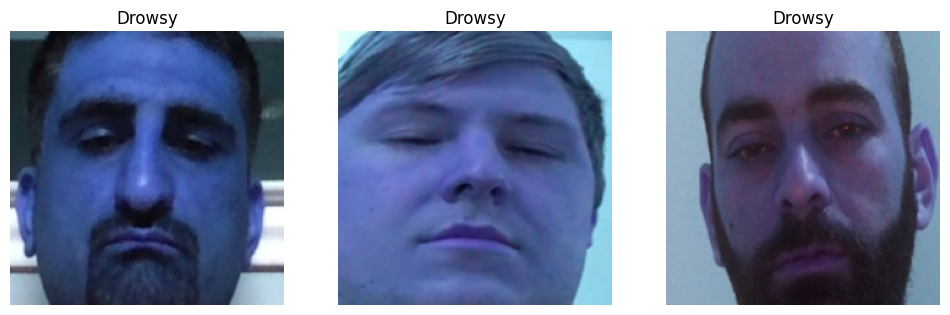

In [7]:
display_random_samples(X_train, y_train, class_names, num_samples=3, class_to_display="Drowsy")

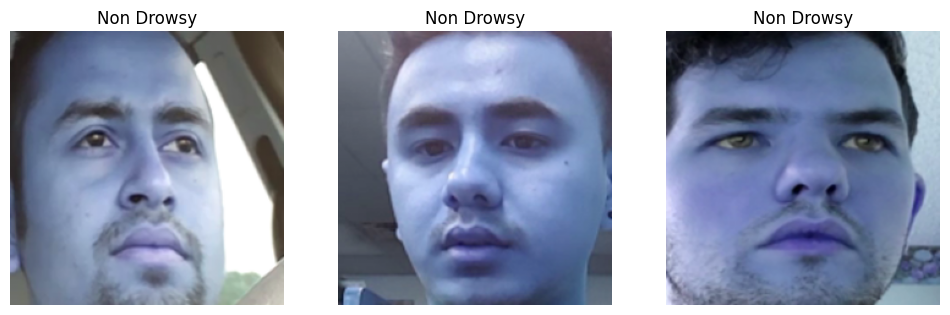

In [8]:
display_random_samples(X_train, y_train, class_names, num_samples=3, class_to_display="Non Drowsy")

## **2. Model Selection**

In [9]:
# Hyperparameter
learning_rate = 0.001
epochs = 25
batch_size = 16

In [10]:
from tensorflow.keras.models import Sequential

base_model = VGG16(input_shape=(224, 224, 3), 
                         include_top=False, 
                         weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## **3. Model training**

In [11]:
model_checkpoint = ModelCheckpoint(os.path.join(folder_path, f"best_model.h5"), monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(os.path.join(folder_path, f"log.csv"), separator=',', append=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Hitung waktu training
start_time = time.time()

# Training
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[model_checkpoint, csv_logger, early_stopping],
    batch_size=batch_size,
)

# Hitung waktu training
end_time = time.time()

print(f"Training Time : {end_time - start_time}")

Epoch 1/25


I0000 00:00:1708461878.624804      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.9391

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/183 [==============================] - 18s 69ms/step - loss: 0.4962 - accuracy: 0.9391 - val_loss: 138.4844 - val_accuracy: 0.9888
Epoch 2/25
183/183 [==============================] - 9s 47ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 137.5239 - val_accuracy: 0.9952
Epoch 3/25
183/183 [==============================] - 9s 47ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 101.4555 - val_accuracy: 0.9952
Epoch 4/25
183/183 [==============================] - 9s 47ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 76.8567 - val_accuracy: 0.9952
Epoch 5/25
183/183 [==============================] - 8s 45ms/step - loss: 0.0166 - accuracy: 0.9956 - val_loss: 422.7952 - val_accuracy: 0.6252
Epoch 6/25
183/183 [==============================] - 8s 45ms/step - loss: 0.0791 - accuracy: 0.9781 - val_loss: 122.7724 - val_accuracy: 0.9362
Epoch 7/25
183/183 [==============================] - 8s 44ms/step - loss: 0.0457 - accuracy: 0.9915 - val_loss: 247.9661 - val_accuracy: 0.9

## **4. Evaluating model**

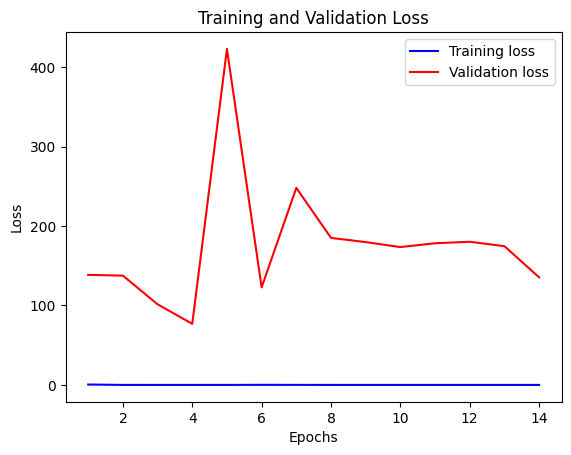

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss.png'))
plt.show()

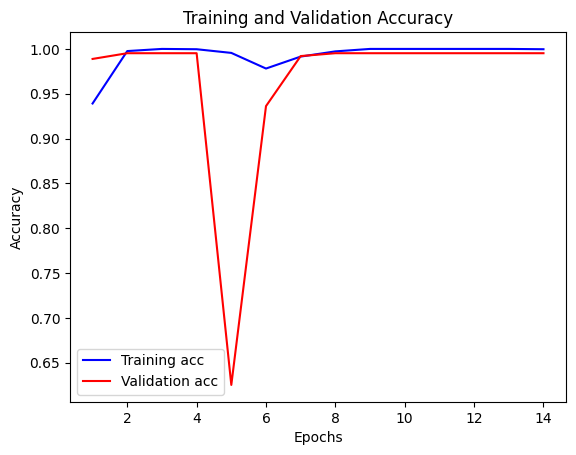

In [13]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy.png'))
plt.show()

In [14]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n", classification_rep)

with open(os.path.join(folder_path, 'classification_report.txt'), 'w') as file:
    file.write(classification_rep)

20/20 [==============================] - 8s 193ms/step
Classification Report:
               precision    recall  f1-score   support

  Non Drowsy     0.9903    0.9968    0.9935       308
      Drowsy     0.9968    0.9906    0.9937       319

    accuracy                         0.9936       627
   macro avg     0.9936    0.9937    0.9936       627
weighted avg     0.9936    0.9936    0.9936       627



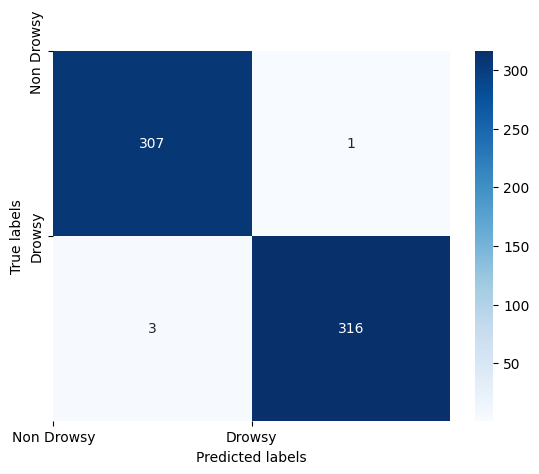

In [15]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(os.path.join(folder_path, 'confusion matrix.png'))
plt.show()